# Projecting conflict risk

In this notebook, we will show how CoPro uses a number of previously fitted classifiers and projects conflict risk forward in time. Eventually, these forward predictions based on multiple classifiers can be merged into a robust estimate of future conflict risk.

## Preparations

Start with loading the required packages.

In [1]:
from copro import utils, pipeline, evaluation, plots, machine_learning

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
from shutil import copyfile
import warnings
import glob
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.8b
geopandas version: 0.9.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


To be able to also run this notebooks, some of the previously saved data needs to be loaded from a temporary location.

In [3]:
conflict_gdf = gpd.read_file(os.path.join('temp_files', 'conflicts.shp'))
selected_polygons_gdf = gpd.read_file(os.path.join('temp_files', 'polygons.shp'))

In [4]:
global_arr = np.load(os.path.join('temp_files', 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

### The configurations-file (cfg-file)

In the cfg-file, all the settings for the analysis are defined. Note that the cfg-file can be stored anywhere, not per se in the same directory where the model data is stored (as in this example case). Make sure that the paths in the cfg-file are updated if you use relative paths and change the folder location of th cfg-file.

Note that only a few settings of the cfg-file are needed for making projections. Most relevant is the path the cfg-file containing the paths to projected variable data to be used for the samples matrix (X). 

In [5]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. Here, the cfg-file is parsed (i.e. read) and all settings and paths become known to the model. Also, the output folder is created (if it does not exist yet) and the cfg-file is copied to the output folder for improved reusability.

In [6]:
main_dict, root_dir = utils.initiate_setup(settings_file, verbose=False)


#### CoPro version 0.0.8b ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2021): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: reading model properties from example_settings.cfg
INFO: verbose mode on: False
INFO: saving output to main folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT


In `main_dict`, the ConfigParser-objects as well as output paths are administered for the reference run and the projection runs specified.

In [7]:
main_dict

{'_REF': [<configparser.RawConfigParser at 0x219f34dfe48>,
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_REF'],
 'proj_nr_1': [[<configparser.RawConfigParser at 0x219f9af1108>],
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_PROJ\\proj_nr_1']}

In [8]:
config_REF = main_dict['_REF'][0]
out_dir_REF = main_dict['_REF'][1] 

In a previous notebook, conflict at the last year of the simulation period as well as classifiers were stored temporarily to another folder than the output folder. Now let's copy these files back to the folder where the belong.

In [9]:
%%capture

for root, dirs, files in os.walk('temp_files'):
    
    # conflicts at last time step
    files = glob.glob(os.path.abspath('./temp_files/conflicts_in*'))
    for file in files:
        fname = file.rsplit('\\')[-1]
        print(fname)
        copyfile(os.path.join('temp_files', fname),
                 os.path.join(out_dir_REF, 'files', str(fname)))
        
    # classifiers
    files = glob.glob(os.path.abspath('./temp_files/clf*'))
    for file in files:
        fname = file.rsplit('\\')[-1]
        print(fname)
        copyfile(os.path.join('temp_files', fname),
                 os.path.join(out_dir_REF, 'clfs', str(fname)))

Similarly, we need to load the sample data (X) for the reference run as we need to fit the scaler with this data before we can make comparable and consistent projections.

In [10]:
config_REF.set('pre_calc', 'XY', str(os.path.join(out_dir_REF, 'XY.npy')))
X, Y = pipeline.create_XY(config_REF, out_dir_REF, root_dir, selected_polygons_gdf, conflict_gdf)

INFO: loading XY data from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\XY.npy


Lastly, we need to get the scaler for the samples matrix again. The pre-computed and already fitted classifiers are directly loaded from file (see above). The clf returned here will not be used.

In [11]:
scaler, clf = pipeline.prepare_ML(config_REF)

## Project!

With this all in place, we can now make projections. Under the hood, various steps are taken for each projectio run specified:

1. Load the corresponding ConfigParser-object;
2. Determine the projection period defined as the period between last year of reference run and projection year specified in cfg-file of projection run;
3. Make a separate projection per classifier:
    1. in the first year of the projection year, use conflict data from last year of reference run, i.e. still observed conflict data;
    2. in all following year, use the conflict data projected for the previous year with this specific classifier;
    3. all other variables are read from file for all years.
4. Per year, merge the conflict risk projected by all classifiers and derive a fractional conflict risk per polygon.

For detailed information, please see the documentatoin and code of `copro.pipeline.run_prediction()`.

In [12]:
all_y_df = pipeline.run_prediction(scaler.fit(X[: , 2:]), main_dict, root_dir, selected_polygons_gdf)

INFO: loading config-object for projection run: proj_nr_1
INFO: the projection period is 2013 to 2015
INFO: making projection for year 2013
INFO: making projection for year 2014
INFO: making projection for year 2015


## Analysis of projection

All the previously used evaluation metrics are not applicable anymore, as there are no target values anymore. We can still look which chance of conflict is computed by the model per polygon.

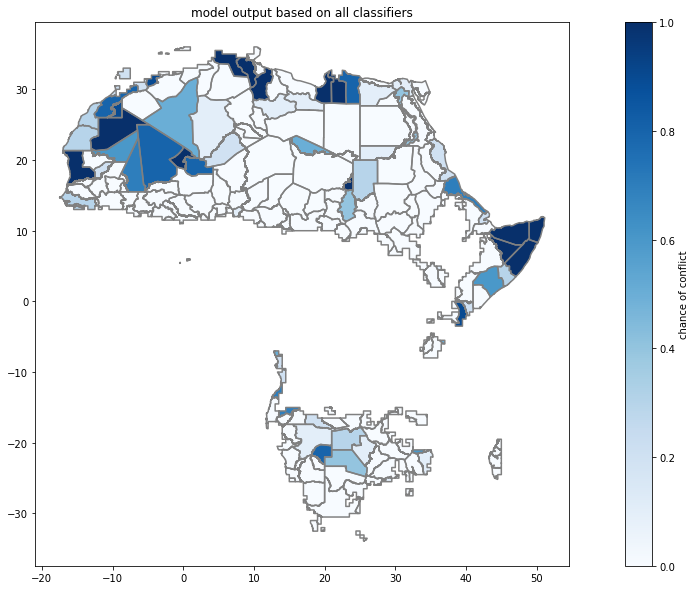

In [13]:
# get the output analysis metrics per chunk that is per classifier
df_hit, gdf_hit = evaluation.polygon_model_accuracy(all_y_df, global_df, make_proj=True)

# and plot them separately
ax = gdf_hit.plot(column='chance_of_conflict', legend=True, figsize=(20, 10), cmap='Blues', vmin=0, vmax=1,
         legend_kwds={'label': "chance of conflict", 'orientation': "vertical"})
ax.set_title('model output based on all classifiers')
selected_polygons_gdf.boundary.plot(ax=ax, color='0.5');

The conflict projection per year is also stored in the output folder of the projection run as geoJSON files.